In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import scanpy as sc
import seaborn as sns
import os

# Perform some standard pre-processing and get an overview of the data

We begin by loading our anndata object from the last notebook (hint: `sc.read_h5ad()`)

In [8]:

ad = sc.read_h5ad('../results/stjude_adata.h5ad')

let's create a new layer named `'counts'` by copying the original count matrix (just to have it ready when we need it later) hint: `ad.X.copy()`

In [9]:

ad.layers['counts'] = ad.X.copy()

In [10]:
ad

AnnData object with n_obs × n_vars = 5292 × 33943
    obs: 'n_counts', 'log10_counts', 'sample_type', 'sj_diseases', 'sj_disease_hierarchy_code', 'sj_disease_hierarchy_name', 'attr_library_selection_protocol', 'tissue', 'system', 'tumor'
    var: 'n_counts', 'log10_counts'
    layers: 'counts'

Now we can apply the standard pre-processing steps: `normalize_total()` and `log1p`. It can be useful to keep the intermediate results as layers `'normed'` and `'log1p'`. So, unless RAM is really tight, let's again copy `.X` at every step.

In [11]:

sc.pp.normalize_total(ad, target_sum=1E6) # more common for sc is target_sum=1E4. Here, we have bulk samples and Counts Per Million (CPM) is appropriate
ad.layers['normed'] = ad.X.copy()
sc.pp.log1p(ad)
ad.layers['log1p'] = ad.X.copy()

time for another classic: detecting highly variable genes (hint `sc.pp.highly_variable_genes()`) let's use the `flavor='cell_ranger'`. (@Aaron: I wish there would be `anglemania` as a choice :) ). We can visualize the impact of the dispersion normalization using `sc.pl.highly_variable_genes` after the fact.

In [12]:

sc.pp.highly_variable_genes(ad, n_top_genes=3000, flavor='cell_ranger')

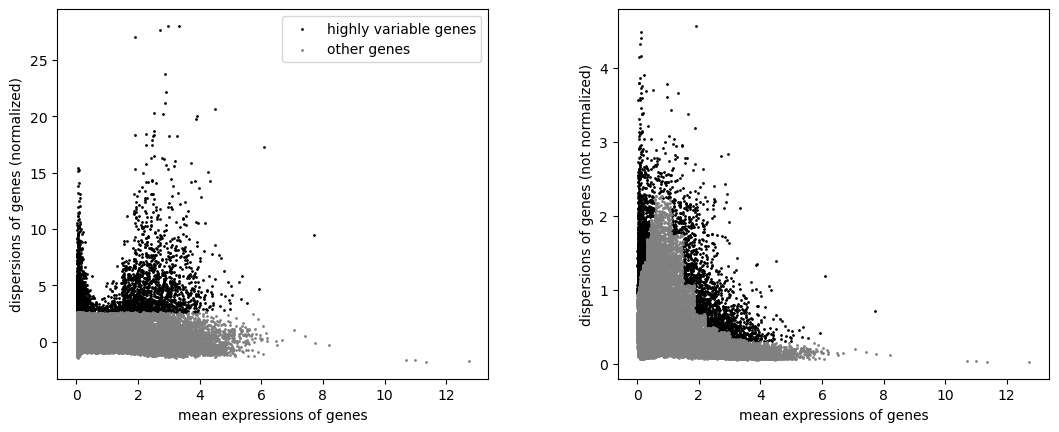

In [13]:

sc.pl.highly_variable_genes(ad)

Oh hey, what if we would like a z-score transformed version of the already log1p, normalized gene expression? That can be very useful for certain tasks. But we do not want this to be the default for everything (that should remain log1p, normalized). How about we first copy to a new layer and then tell `sc.pp.scale` to use that layer instead of the default `.X` ? Can you do it?

In [14]:

ad.layers['scaled'] = ad.X.copy()
sc.pp.scale(ad, layer='scaled') # do not replace .X but have a scaled layer at hand

## PCA
Alright! Great! Time for some dimensionality reduction. Let's run principal component analysis, identify k-nearest neighbors and get an overview of our data. hint: `sc.pp.pca(), sc.pp.neighbors(), sc.pl.pca_overview(..., color=[<obs columns of choice>])`. Perhaps any of these metadata columns is associate with PC1 or PC2? `'tissue', 'attr_library_selection_protocol', 'sample_type', 'system'`

In [18]:

sc.pp.pca(ad)

In [19]:

sc.pp.neighbors(ad)

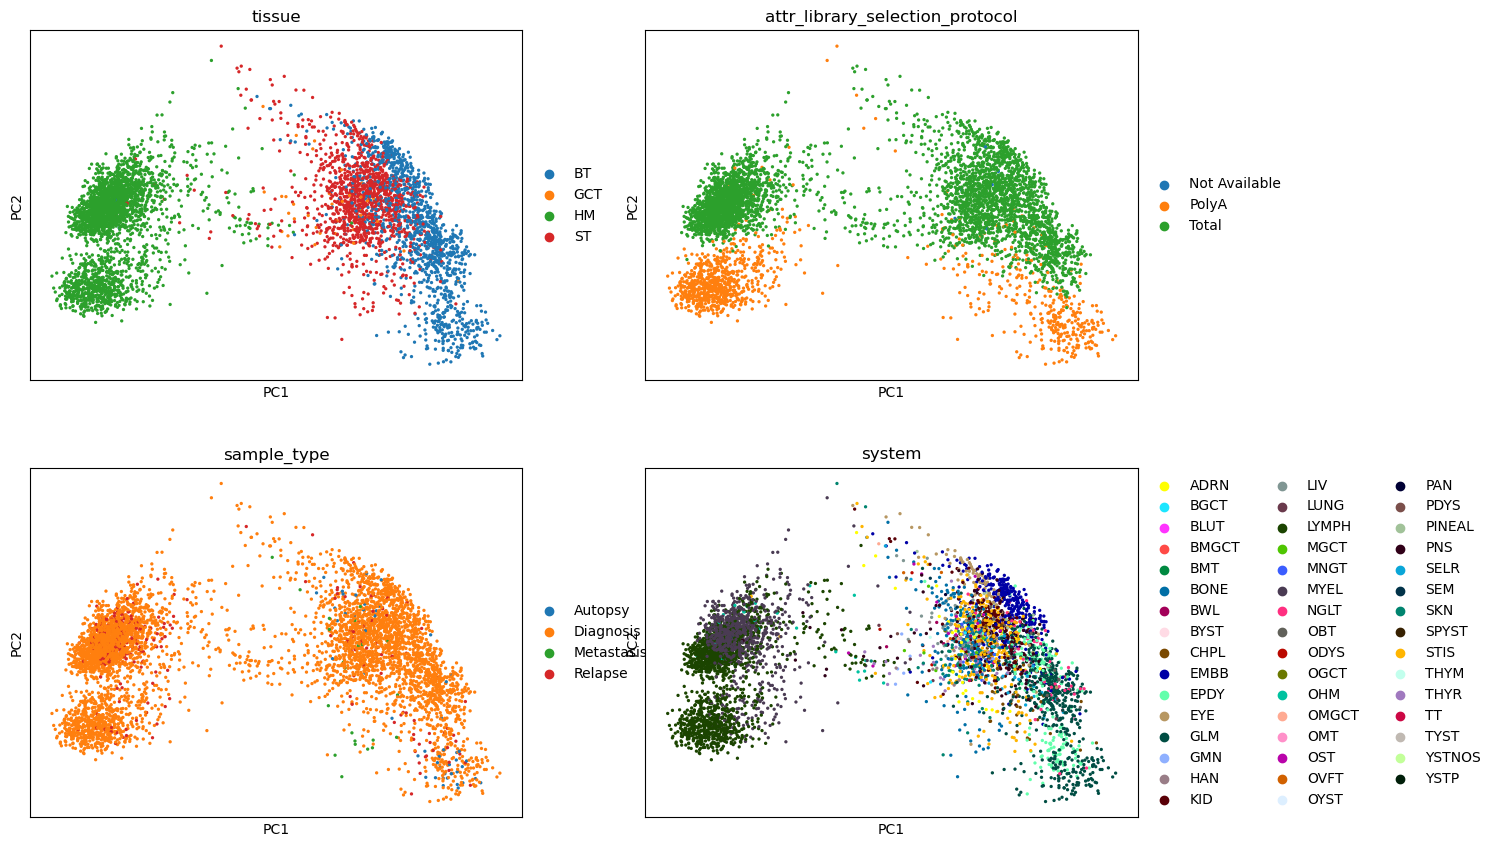

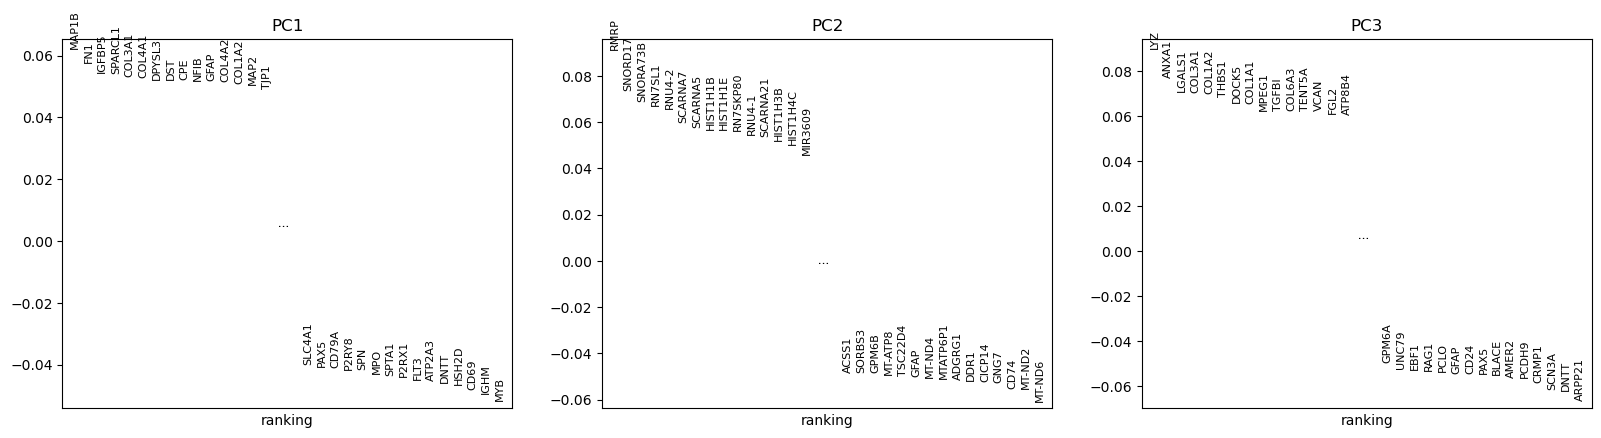

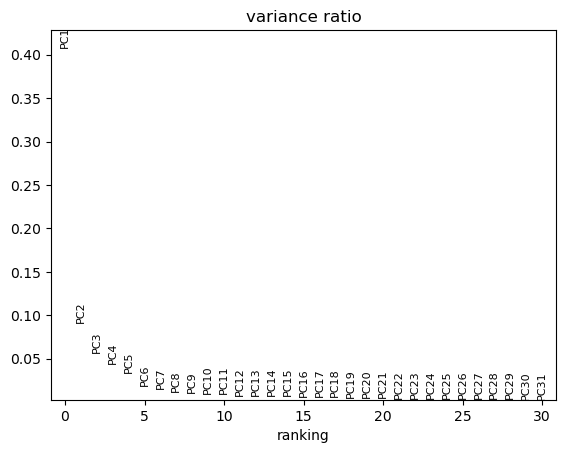

In [20]:

sc.pl.pca_overview(ad, color=['tissue', 'attr_library_selection_protocol', 'sample_type', 'system'], ncols=2)

In [21]:

#NB = ad.obs['tumor'].str.contains('Neuroblastoma')

## UMAP

Time for the more fashionable dimensionality reduction Uniform Manifold Approximation and Projection (UMAP). This can show much more fine-structure in the data than PCA, but please be aware that this comes at considerable costs! The results are to a certain degree random, no longer linear, and distances/angles etc. do not mean much beyond close points (samples/cells) should be more similar in gene expression than distant points. Best to treat UMAPs as an *illustration* of your data, closer to a cartoon than most other result-plots! hint: `sc.tl.umap()` to compute the projection and `sc.pl.umap(.. color=[...])` for the actual plot. 


In [22]:

sc.tl.umap(ad)

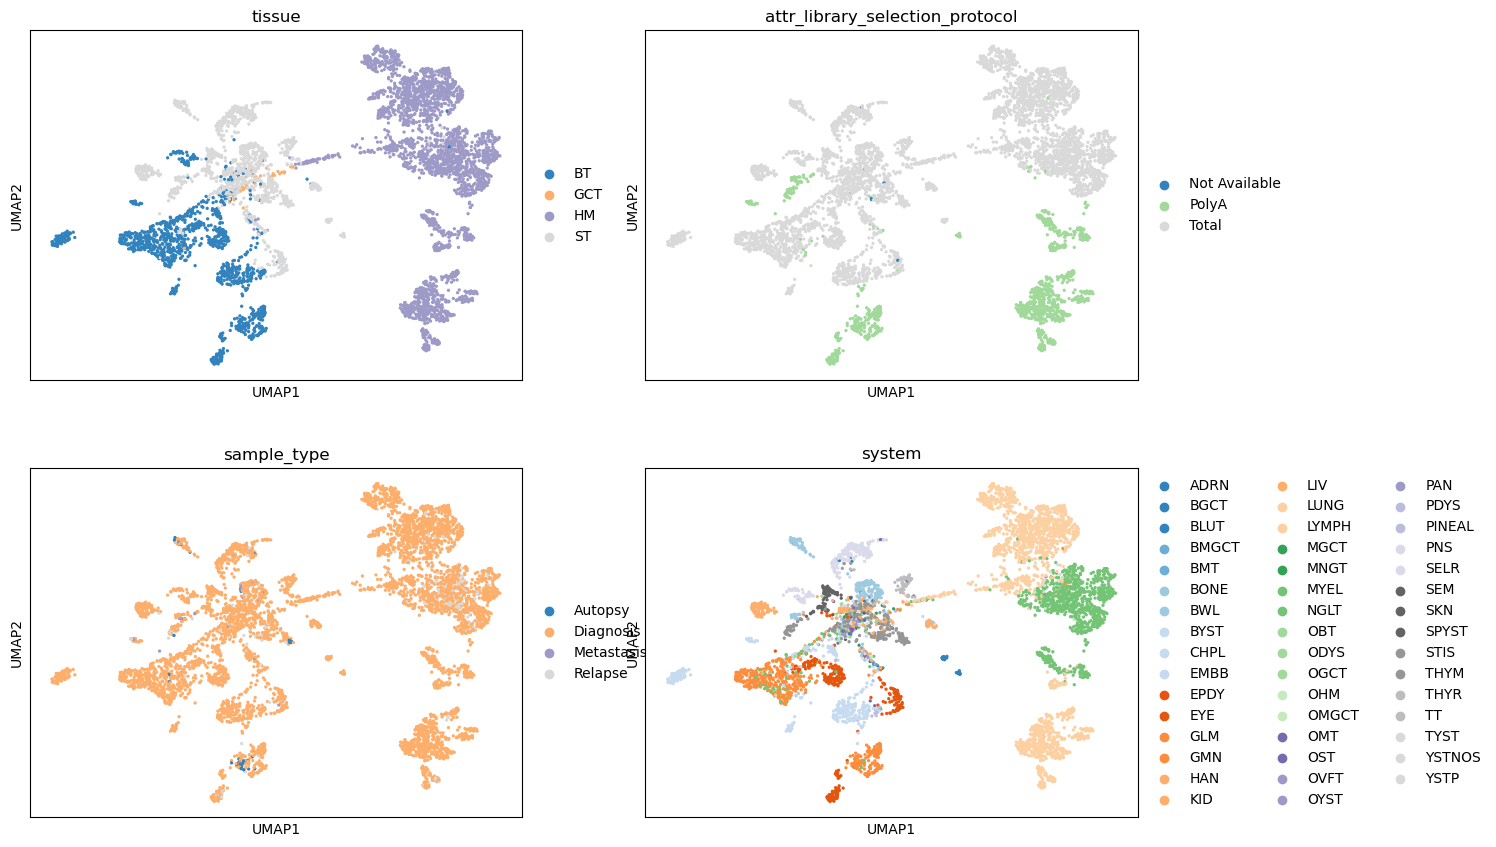

In [23]:

sc.pl.umap(ad, color=['tissue', 'attr_library_selection_protocol', 'sample_type', 'system'], palette='tab20c', ncols=2)

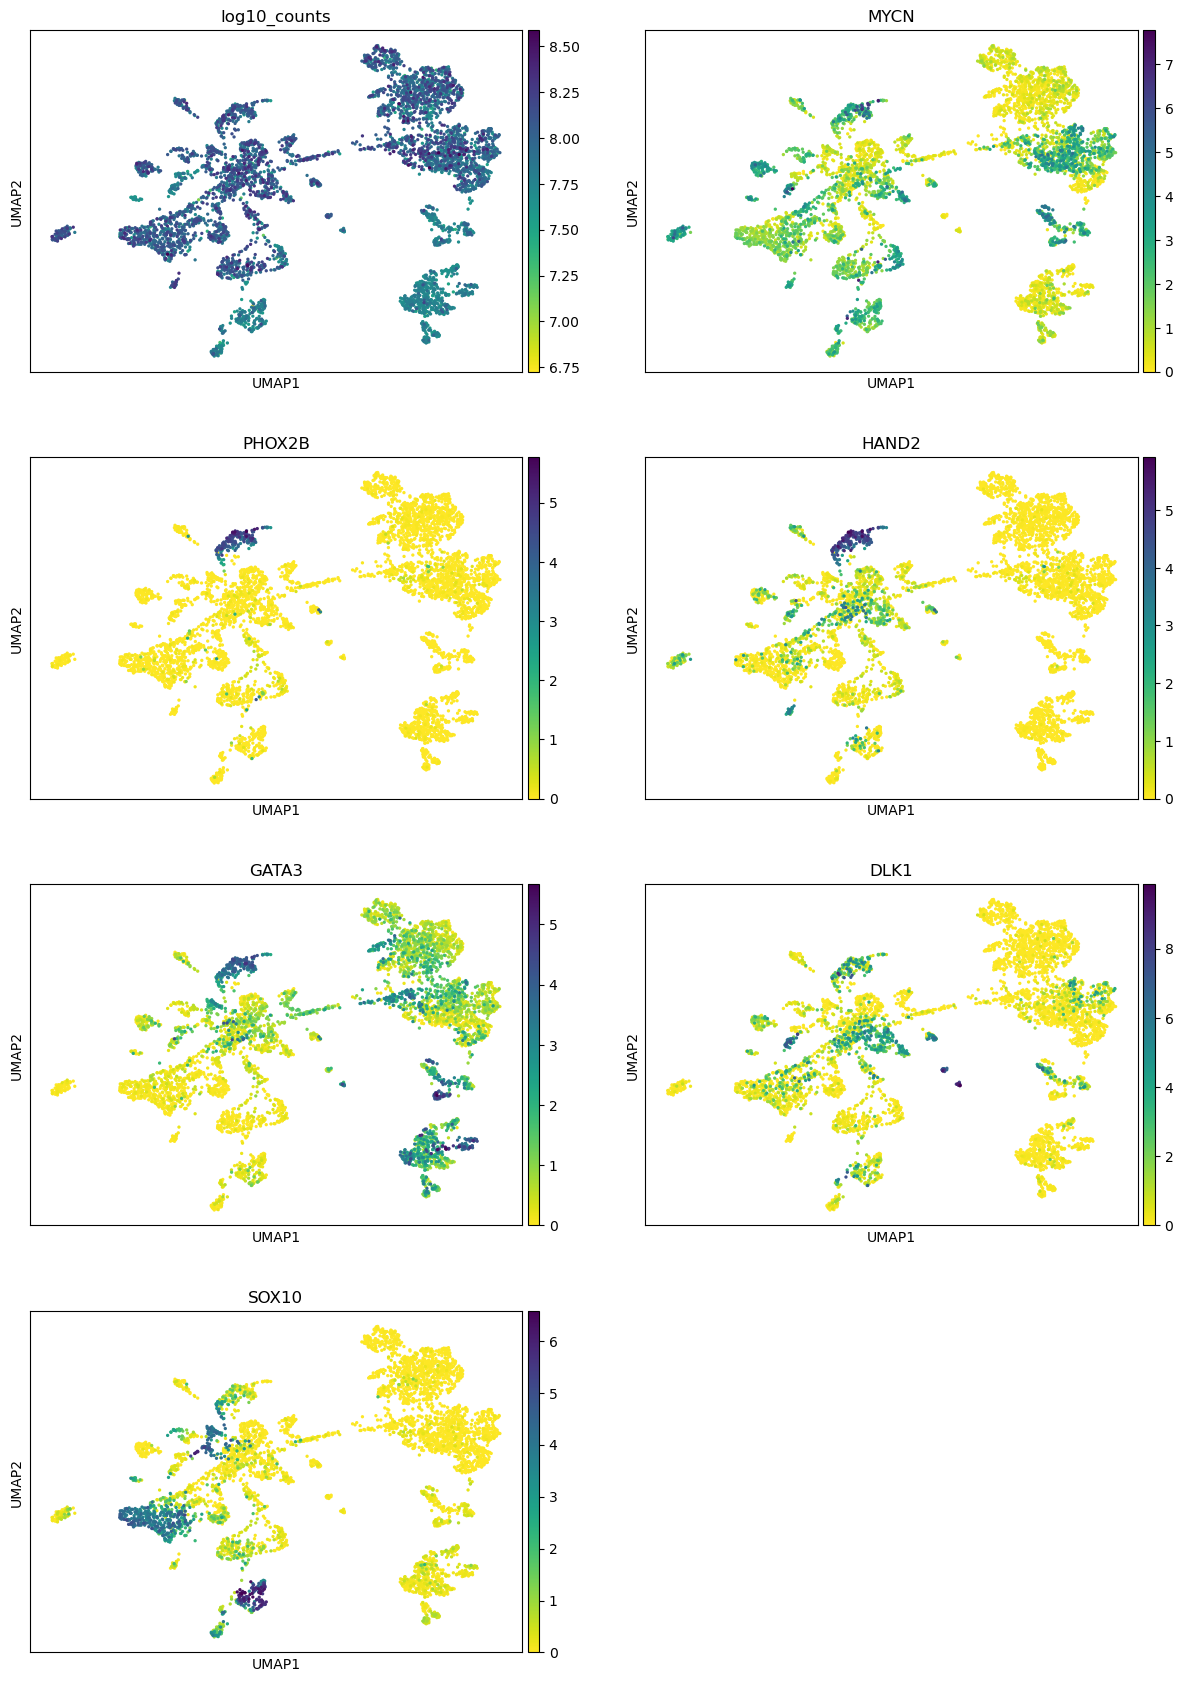

In [24]:

sc.pl.umap(ad, color=['log10_counts', 'MYCN', 'PHOX2B', 'HAND2', 'GATA3', 'DLK1', 'SOX10'], cmap='viridis_r', ncols=2, palette='Set2')

## Leiden clustering

Okay, so if UMAP is not a real result, how else to make sense of the transcriptional diversity in front of us? The OG approach is clustering, a decades old art with tons of details. However, to cluster (normalized, logged) gene expression data, leiden clustering gives pretty good results. (hint: `sc.tl.leiden()`). For an anndata object, that essentially adds a label `leiden` to `.obs`. So we can easily show the assigned cluster labels on top of the UMAP.

In [25]:

sc.tl.leiden(ad, flavor="igraph", n_iterations=2, resolution=5)

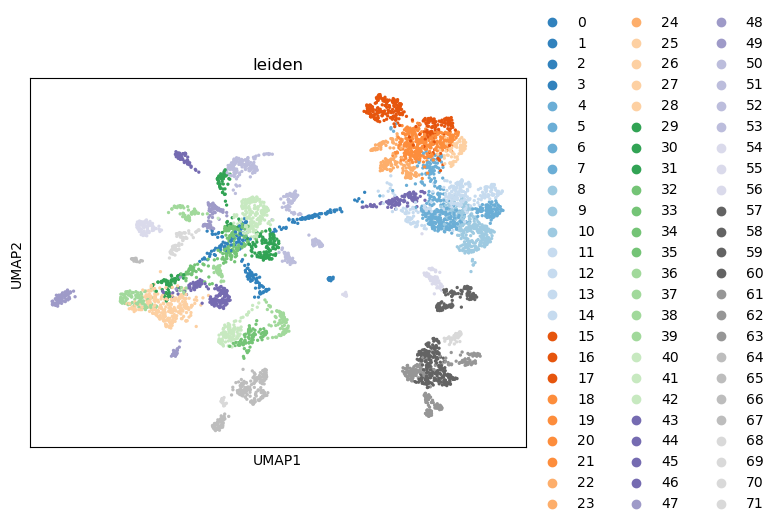

In [26]:

sc.pl.umap(ad, color=['leiden'], palette='tab20c', ncols=2)

## Relationship between clusters and tumor identity

We get way fewer clusters than tumor types. Although we already know that individual tumors are represented sometimes twice, with total RNA and polyA RNA selection. Which tumors are clustered together? Let's select only the `'attr_library_selection_protocol'` `'Total'` samples and perform a `pd.crosstab` between `leiden` and `tumor` columns in `.obs`

In [28]:

adt = ad[ad.obs['attr_library_selection_protocol'] == 'Total'].copy()

/opt/micromamba/envs/crc1588-sc-atlas/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/micromamba/envs/crc1588-sc-atlas/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


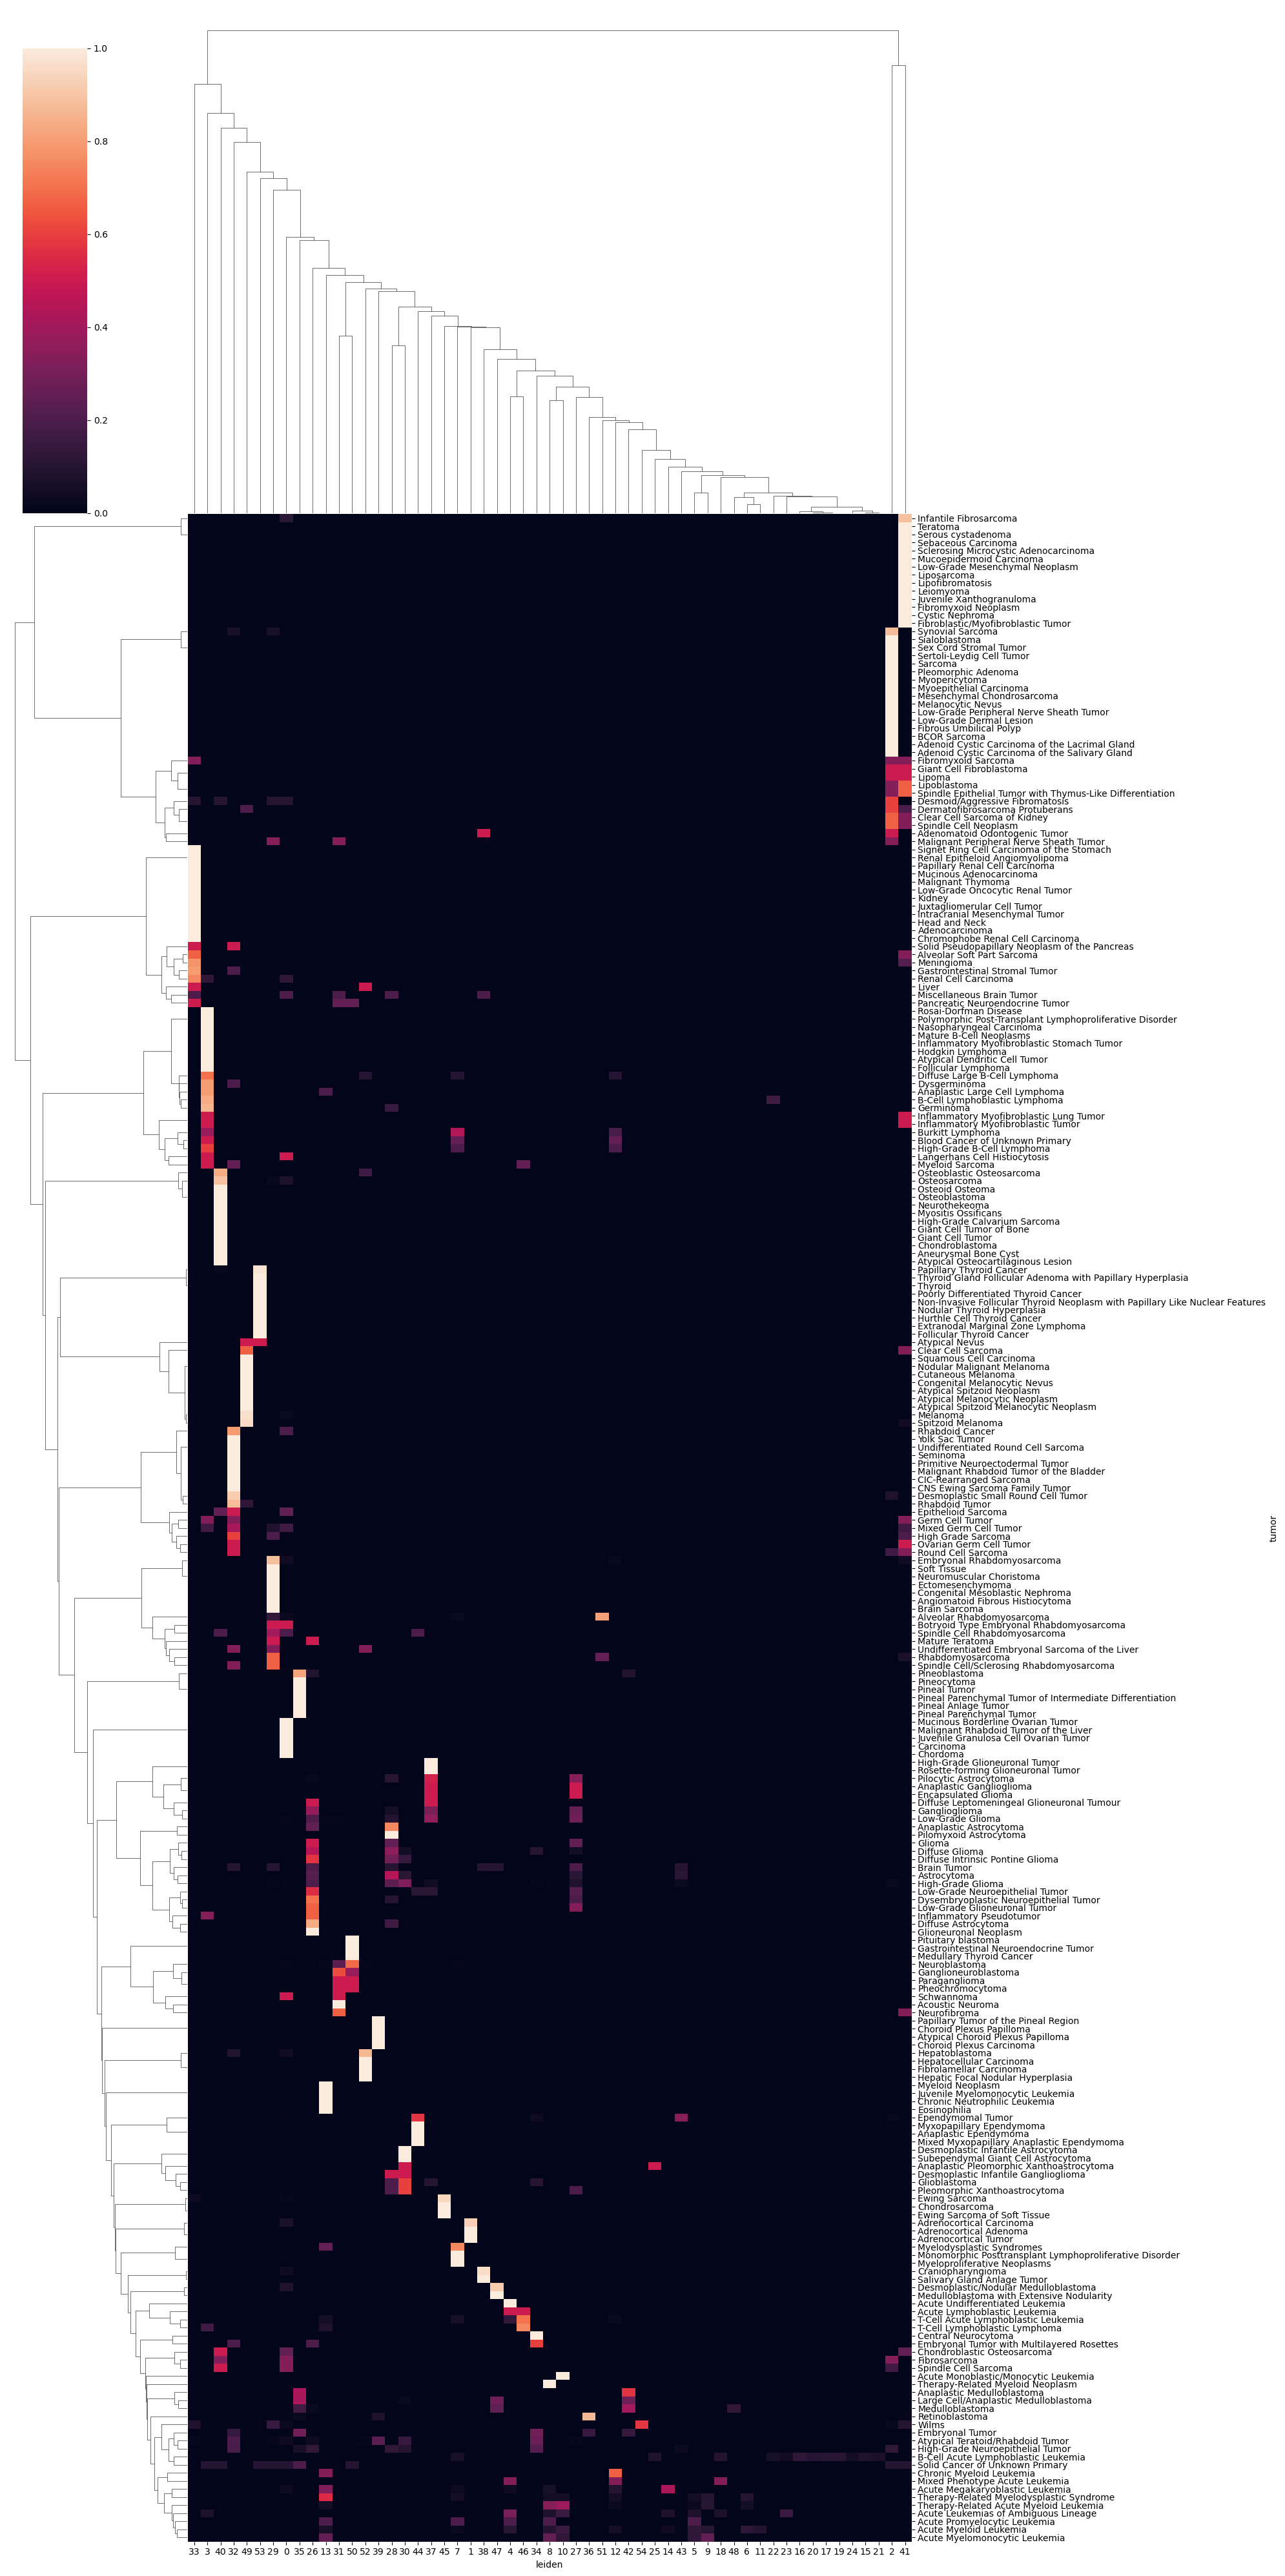

In [42]:

sns.clustermap(pd.crosstab(adt.obs['tumor'], adt.obs['leiden'], normalize='index'), method='ward', xticklabels=True, yticklabels=True, figsize=(20,40))

So, as usual, we have a bit of everything: metadata inconsistencies ("Adrenocortical Carcinoma/Adenoma/Tumor"), *transcriptionally* very similar tumors that however may be named differently depending on where they grow, as well as some tumors with the same name that look transcriptionally *different*. And perhaps one should even expect a few mis-diagnoses, some of these may look very similar.

If we really want to, we could ask which tumors express SOX10 (Neural-Crest marker) and MYCN? At (arbitrarily) chosen SOX10 levels of > 0.5 and MYCN > 2 we get a somewhat managable list. hint: threshold on the genes to subset `ad`, then select `tumor` from `.obs` and use `.value_counts()` to get the number of samples of each SOX10+,MYCN+ tumor in the catalog.

<Axes: xlabel='count', ylabel='tumor'>

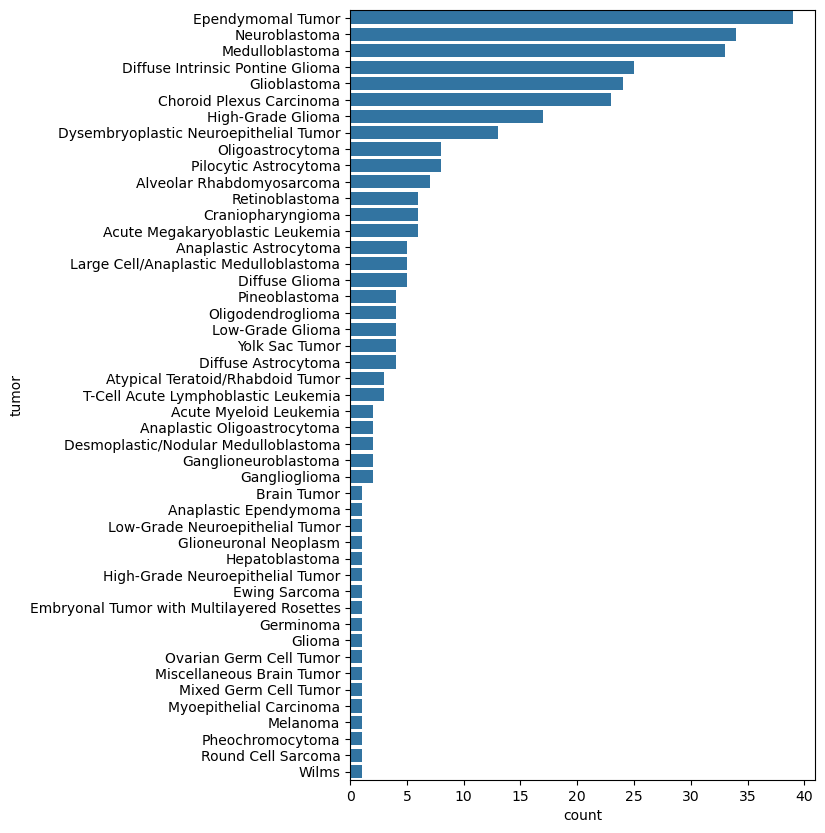

In [48]:

dcounts = ad[(ad[:, 'SOX10'].X > 0.5) & (ad[:, 'MYCN'].X > 2)].obs['tumor'].value_counts()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(data=dcounts, ax=ax, orient='h', order=dcounts.sort_values(ascending=False).index)

Apparently, there are quite a few tumor entities "nearby". Let's find out which genes set apart Neuroblastoma amongs all tumors of the peripheral nervous system (hint: `.obs['system'] == 'PNS'`). 

## Marker genes

To identify marker genes, we need at least 2 samples for each group, so 'Neuromuscular Choristoma' has to go. Once we have our subset, let's run `sc.tl.rank_genes_groups` using `'tumor'` as group and method `wilcoxon` (rank-based).

In [49]:

PNS = ad.obs['system'] == 'PNS' # peripheral nervous system
ad[PNS].obs['tumor'].value_counts()

tumor
Neuroblastoma                              163
Ganglioneuroblastoma                         8
Malignant Peripheral Nerve Sheath Tumor      3
Neurofibroma                                 3
Low-Grade Peripheral Nerve Sheath Tumor      2
Schwannoma                                   2
Neuromuscular Choristoma                     1
Name: count, dtype: int64

In [50]:

PNSv = PNS & (ad.obs['tumor'] != 'Neuromuscular Choristoma')

In [51]:

ad_pns = ad[PNSv].copy()

In [52]:

ad_pns.obs['tumor'].value_counts()

tumor
Neuroblastoma                              163
Ganglioneuroblastoma                         8
Neurofibroma                                 3
Malignant Peripheral Nerve Sheath Tumor      3
Low-Grade Peripheral Nerve Sheath Tumor      2
Schwannoma                                   2
Name: count, dtype: int64

In [53]:

sc.tl.rank_genes_groups(ad_pns, 'tumor', method='wilcoxon') 

We can extract the marker genes as a dataframe using `sc.get.rank_genes_groups_df()`

In [80]:

df = sc.get.rank_genes_groups_df(ad_pns, group=None, log2fc_min=2, pval_cutoff=1) # P-values are sh#t since the sample numbers are so unequal and low for most PNS tumors.
df

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,Ganglioneuroblastoma,IGHG4,4.017074,3.230320,0.000059,0.588613
1,Ganglioneuroblastoma,ACKR1,3.872128,2.108179,0.000108,0.588613
2,Ganglioneuroblastoma,ANGPTL7,3.865226,2.912725,0.000111,0.588613
3,Ganglioneuroblastoma,IGKV1D-39,3.651258,3.205430,0.000261,0.588613
4,Ganglioneuroblastoma,IGKV1-39,3.609845,2.469334,0.000306,0.588613
...,...,...,...,...,...,...
12360,Schwannoma,SCN1A-AS1,0.135710,2.231087,0.892050,0.946747
12361,Schwannoma,LINC00836,0.094997,2.043873,0.924317,0.962454
12362,Schwannoma,AC008555.2,0.094997,2.217350,0.924317,0.962454
12363,Schwannoma,LINC00964,0.047499,2.124149,0.962116,0.982552


In [81]:

df['group'].drop_duplicates()

0                          Ganglioneuroblastoma
110     Low-Grade Peripheral Nerve Sheath Tumor
3532    Malignant Peripheral Nerve Sheath Tumor
5041                              Neuroblastoma
5519                               Neurofibroma
6960                                 Schwannoma
Name: group, dtype: category
Categories (6, object): ['Ganglioneuroblastoma', 'Low-Grade Peripheral Nerve Sheath Tumor', 'Malignant Peripheral Nerve Sheath Tumor', 'Neuroblastoma', 'Neurofibroma', 'Schwannoma']

In [77]:

n_top = 4
ttypes_dict = df.sort_values('scores', ascending=False).groupby("group").head(n_top).groupby("group")["names"].apply(lambda x: list(x)).to_dict()
ttypes_dict

{'Ganglioneuroblastoma': ['IGHG4', 'ACKR1', 'ANGPTL7', 'IGKV1D-39'],
 'Low-Grade Peripheral Nerve Sheath Tumor': ['AC079834.2',
  'AC055854.1',
  'FBXO39',
  'AC009435.1'],
 'Malignant Peripheral Nerve Sheath Tumor': ['TRPS1',
  'FZD6',
  'CCND2',
  'LINC02328'],
 'Neuroblastoma': ['NRG3', 'ADAM22', 'LRFN2', 'RIMBP2'],
 'Neurofibroma': ['PTCH1', 'AL354861.3', 'AL357832.1', 'ABCA9'],
 'Schwannoma': ['ATP8B5P', 'DEFB124', 'LINC02669', 'OR4F15']}

Let's make a dotplot that shows us which genes set NB apart, among the 6 PNS malignancies in our catalog. (hint: `sc.pl.rank_genes_groups_dotplot()`)

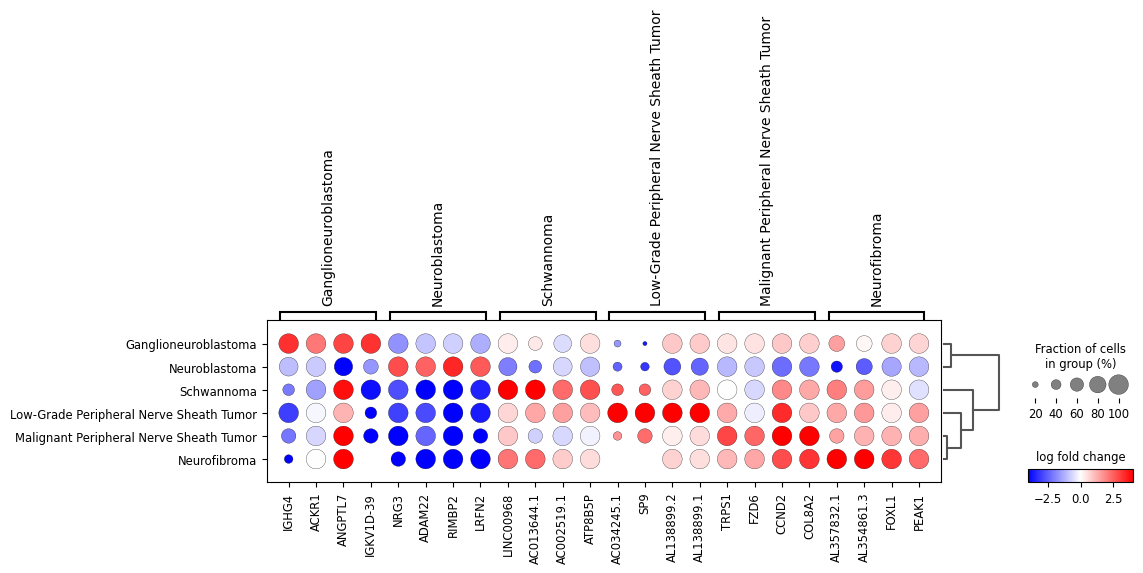

In [82]:

sc.pl.rank_genes_groups_dotplot(ad_pns, min_logfoldchange=2, values_to_plot="logfoldchanges", cmap='bwr', vmin=-4, vmax=4, n_genes=4)

Time to save our results! Let's keep both, the PNS only (`'../results/stjude_pns.h5ad') and the entire collection -- but now with all the bells and whistles -- (`'../results/stjude_clustered.h5ad'`).

In [83]:

ad_pns.write_h5ad('../results/stjude_pns.h5ad')

In [84]:

ad.write_h5ad('../results/stjude_clustered.h5ad')